In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import geopandas as gp
# %matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
# from mpl_toolkits.basemap import Basemap
import math
import osmnx as ox
import networkx as nx
import pickle
from sklearn.cluster import KMeans
from shapely.geometry import LineString
import transbigdata as tbd
import os
from tqdm import tqdm
from shapely import geometry
import pygeos

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

# 1 Import Data

In [ ]:
county_sz = gp.GeoDataFrame.from_file(r'D://005城中村OD//data//shenzhen_trace3//data//Boundary//Shenzhen.shp')

In [ ]:
county_sz.to_crs('epsg:4326',inplace=True)
county_sz.crs

In [ ]:
county_sz[['cent_lng','cent_lat']] = county_sz['geometry'].apply(lambda x: pd.Series(x.centroid.coords[0]))

In [ ]:
county_sz

In [61]:
# Import hexagons
grid_sz = gp.GeoDataFrame.from_file('D://004Vitality//02-Data//Hexagons_for_analysis//hexagons.shp')
grid_point = gp.GeoDataFrame.from_file('D://004Vitality//02-Data//Hexagons_for_analysis//hexagons_point.shp')

In [62]:
grid_sz.crs

<Derived Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°E and 120°E, northern hemisphere between equator and 84°N, onshore and offshore. Brunei. China. Hong Kong. Indonesia. Malaysia - East Malaysia - Sarawak. Mongolia. Philippines. Russian Federation. Taiwan.
- bounds: (114.0, 0.0, 120.0, 84.0)
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
grid_point.crs

<Derived Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°E and 120°E, northern hemisphere between equator and 84°N, onshore and offshore. Brunei. China. Hong Kong. Indonesia. Malaysia - East Malaysia - Sarawak. Mongolia. Philippines. Russian Federation. Taiwan.
- bounds: (114.0, 0.0, 120.0, 84.0)
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

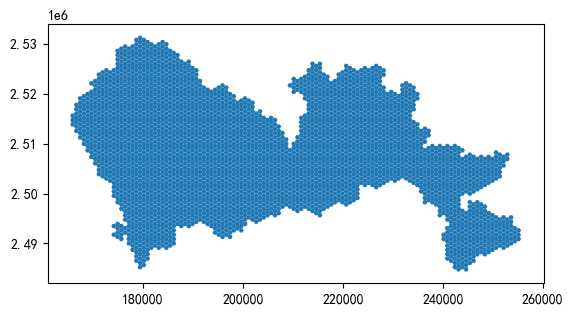

In [64]:
grid_sz.plot()

<AxesSubplot:>

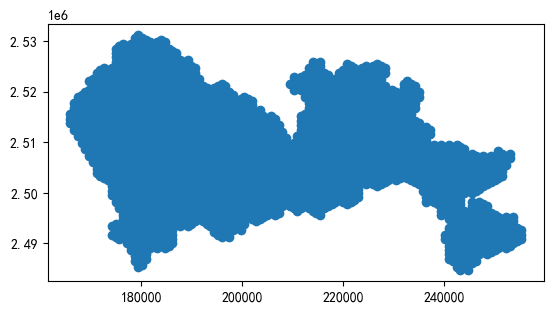

In [65]:
grid_point.plot()

In [6]:
# Grid centroid
grid_sz[['grid_lng','grid_lat']] = grid_sz['geometry'].apply(lambda x: pd.Series(x.centroid.coords[0]))

In [7]:
grid_sz.head(5)

,Id,Input_FID,geometry,grid_lng,grid_lat
0,0,0,"POLYGON ((113.83553 22.50517, 113.83805 22.50131, 113.83571 22.49736, 113.83086 22.49727, 113.82...",113.833196,22.501219
1,0,1,"POLYGON ((113.84290 22.50141, 113.84542 22.49755, 113.84308 22.49360, 113.83823 22.49350, 113.83...",113.840566,22.497457
2,0,2,"POLYGON ((113.84255 22.51703, 113.84506 22.51318, 113.84273 22.50922, 113.83787 22.50913, 113.83...",113.840211,22.513080
3,0,3,"POLYGON ((113.84273 22.50922, 113.84524 22.50536, 113.84290 22.50141, 113.83805 22.50131, 113.83...",113.840388,22.505268
4,0,4,"POLYGON ((113.84237 22.52485, 113.84489 22.52099, 113.84255 22.51703, 113.83769 22.51694, 113.83...",113.840033,22.520892


In [ ]:
# nx.get_edge_attributes(streets_graph, (72564005, 6718489746))
# nx.get_node_attributes(streets_graph, 72564005)
# nx.number_of_edges(streets_graph)
# nx.is_weighted(streets_graph, edge=(72564005, 6718489746), weight='length')
# streets_graph.edges()

In [1]:
# # Convert road network to GeoDataFrame
# # streets = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

# # Plotting the road network
# fig, ax = plt.subplots(figsize=(10, 6))
# streets.plot(ax=ax, linewidth=0.2)
# ax.set_axis_off()  # Remove axis for a cleaner plot
# ax.set_xlim(113.75, 114.7)  # Set x-axis limits
# ax.set_ylim(22.45, 22.9)    # Set y-axis limits

# # Uncomment to save the plot as an SVG file
# # plt.savefig('../out/pic/roadnet_shenzhen.svg')

# plt.show()

# 2 Trajectory Processing

In [9]:
trace = pd.read_csv('D://004Vitality//02-Data//bike_out//trace_processed.csv', index_col=0)
trace.head(5)

,Unnamed: 0.1,Unnamed: 0,USER_ID,START_TIME,START_LNG_bd09,START_LAT_bd09,END_TIME,END_LNG_bd09,END_LAT_bd09,START_LNG_wgs84,START_LAT_wgs84,END_LNG_wgs84,END_LAT_wgs84,cycling_time_sec,cycling_time_min,Stime_h,geometry,o_FID,d_FID
0,0,0,b39096e5174f44674130cf**********,2021-02-01 00:00:24,113.826432,22.750422,2021-02-01 00:01:57,113.827118,22.751765,113.814820,22.747672,113.815509,22.749017,93,1.550000,0,POINT (113.81482040208104 22.74767248068176),1013.0,1013.0
1,2,2,ddd35bc57d2034cd5d6202**********,2021-02-01 00:01:05,114.039482,22.658766,2021-02-01 00:02:12,114.041778,22.660208,114.027911,22.655579,114.030194,22.657056,67,1.116667,0,POINT (114.027910523474 22.65557949389264),1553.0,1553.0
2,3,3,27a3b619ac69f9b601da16**********,2021-02-01 00:01:37,114.124361,22.564188,2021-02-01 00:03:15,114.125867,22.564105,114.112828,22.560536,114.114338,22.560453,98,1.633333,0,POINT (114.1128283023812 22.56053632192188),702.0,681.0
3,4,4,fa12ab71f9f905def012b1**********,2021-02-01 00:00:50,113.967122,22.682608,2021-02-01 00:03:14,113.965550,22.685399,113.955681,22.679728,113.954104,22.682545,144,2.400000,0,POINT (113.9556810305695 22.67972823355424),1178.0,1178.0
4,5,5,b810dc45e3f15b23d1cb46**********,2021-02-01 00:00:50,113.967063,22.682549,2021-02-01 00:03:14,113.965491,22.685340,113.955622,22.679670,113.954045,22.682487,144,2.400000,0,POINT (113.95562211952932 22.67967043015974),1178.0,1178.0


In [4]:
# Filter out non-null values, resulting in 1,385,518 trajectories
trace = trace[trace['o_FID'].notnull()]  # Filter rows where 'o_FID' is not null
trace = trace[trace['d_FID'].notnull()]  # Filter rows where 'd_FID' is not null

In [5]:
# trace = pd.read_csv('D://004Vitality//02-Data//trace_test.csv')
# trace.head(5)

In [10]:
trace.shape

(1416605, 19)

In [ ]:
# Convert time format
trace['START_TIME'] = pd.to_datetime(trace['START_TIME'], format='%Y-%m-%d %H:%M:%S')
trace['END_TIME'] = pd.to_datetime(trace['END_TIME'], format='%Y-%m-%d %H:%M:%S')
trace['o_FID'] = trace['o_FID'].astype(int)
trace['d_FID'] = trace['d_FID'].astype(int)

# Calculate stop duration in seconds and minutes
# trace['cycling_time_sec'] = (trace['END_TIME'] - trace['START_TIME']).dt.seconds
# trace['cycling_time_min'] = (trace['END_TIME'] - trace['START_TIME']).dt.total_seconds() / 60

# Label the time period of each trajectory
# trace['Stime_h'] = trace['START_TIME'].dt.hour

In [ ]:
trace.tail(5)

### Remove Trajectories Under One Minute
- Original data: 1,438,225 records
- Over one minute: 1,416,605 records

In [ ]:
# trace_1min = trace[(trace['cycling_time_sec']>=60)]
# trace_1min.to_csv('D://004Vitality//02-Data//shared_bikes_20210201_processed_valid.csv')
# trace_2min = trace[(trace['cycling_time_sec']>=120)]
# trace_5min = trace[(trace['cycling_time_sec']>=300)]
# trace_10min = trace[(trace['cycling_time_sec']>=600)]
# print(trace_1min.shape[0])
# print(trace_2min.shape[0])
# print(trace_5min.shape[0])
# print(trace_10min.shape[0])

In [17]:
trace.head(5)

,Unnamed: 0.1,Unnamed: 0,USER_ID,START_TIME,START_LNG_bd09,START_LAT_bd09,END_TIME,END_LNG_bd09,END_LAT_bd09,START_LNG_wgs84,START_LAT_wgs84,END_LNG_wgs84,END_LAT_wgs84,cycling_time_sec,cycling_time_min,Stime_h,geometry,o_FID,d_FID
0,0,0,b39096e5174f44674130cf**********,2021-02-01 00:00:24,113.826432,22.750422,2021-02-01 00:01:57,113.827118,22.751765,113.814820,22.747672,113.815509,22.749017,93,1.550000,0,POINT (113.81482040208104 22.74767248068176),1013.0,1013.0
1,2,2,ddd35bc57d2034cd5d6202**********,2021-02-01 00:01:05,114.039482,22.658766,2021-02-01 00:02:12,114.041778,22.660208,114.027911,22.655579,114.030194,22.657056,67,1.116667,0,POINT (114.027910523474 22.65557949389264),1553.0,1553.0
2,3,3,27a3b619ac69f9b601da16**********,2021-02-01 00:01:37,114.124361,22.564188,2021-02-01 00:03:15,114.125867,22.564105,114.112828,22.560536,114.114338,22.560453,98,1.633333,0,POINT (114.1128283023812 22.56053632192188),702.0,681.0
3,4,4,fa12ab71f9f905def012b1**********,2021-02-01 00:00:50,113.967122,22.682608,2021-02-01 00:03:14,113.965550,22.685399,113.955681,22.679728,113.954104,22.682545,144,2.400000,0,POINT (113.9556810305695 22.67972823355424),1178.0,1178.0
4,5,5,b810dc45e3f15b23d1cb46**********,2021-02-01 00:00:50,113.967063,22.682549,2021-02-01 00:03:14,113.965491,22.685340,113.955622,22.679670,113.954045,22.682487,144,2.400000,0,POINT (113.95562211952932 22.67967043015974),1178.0,1178.0


## Distribution of Cycling Duration and Time Periods

In [39]:
time_list = []
for i in range(24):
    time_list.append(i)
print(time_list)
time_df = pd.DataFrame(time_list, columns=['time'])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [36]:
trace_time = pd.DataFrame(index=time_df['time'].values)
trace_time['mins0-5'] = trace[(trace['cycling_time_min']>=0)&(trace['cycling_time_min']<5)].groupby('Stime_h').apply(lambda x: x.shape[0])
trace_time['mins5-10'] = trace[(trace['cycling_time_min']>=5)&(trace['cycling_time_min']<10)].groupby('Stime_h').apply(lambda x: x.shape[0])
trace_time['mins10-20'] = trace[(trace['cycling_time_min']>=10)&(trace['cycling_time_min']<20)].groupby('Stime_h').apply(lambda x: x.shape[0])
trace_time['mins20-30'] = trace[(trace['cycling_time_min']>=20)&(trace['cycling_time_min']<30)].groupby('Stime_h').apply(lambda x: x.shape[0])
trace_time['mins30'] = trace[trace['cycling_time_min']>=30].groupby('Stime_h').apply(lambda x: x.shape[0])

In [41]:
trace_time

,mins0-5,mins5-10,mins10-20,mins20-30,mins30
0,3104,5205,3990,1103,857
1,1734,2595,1740,501,547
2,1216,1765,1322,377,411
3,865,1306,821,191,267
4,929,1276,991,273,268
5,1678,2675,1994,569,425
6,7880,11331,7498,1620,902
7,39184,49993,29936,6645,2899
8,54508,72228,46181,9766,3747
9,24483,29428,16966,3531,2465


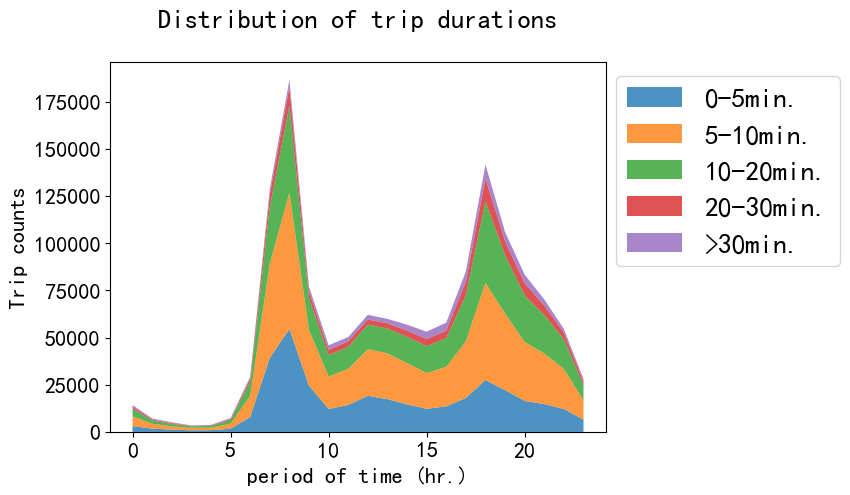

In [60]:
year = time_list
population_by_continent = {
    '0-5min.': trace_time['mins0-5'].tolist(),
    '5-10min.': trace_time['mins5-10'].tolist(),
    '10-20min.': trace_time['mins10-20'].tolist(),
    '20-30min.': trace_time['mins20-30'].tolist(),
    '>30min.': trace_time['mins30'].tolist(),
}

fig, ax = plt.subplots()
ax.stackplot(year, population_by_continent.values(),
             labels=population_by_continent.keys(), alpha=0.8)
ax.legend(loc='best', bbox_to_anchor=(1.5, 1))
ax.set_title('Distribution of trip durations\n')
ax.set_xlabel('period of time (hr.)')
ax.set_ylabel('Trip counts')

plt.show()

## Distribution of Cycling Duration for Trips Under 30 Minutes

In [12]:
duration_secs = trace['cycling_time_sec']
duration_mins = trace['cycling_time_min']

Text(0, 0.5, 'Trip counts')

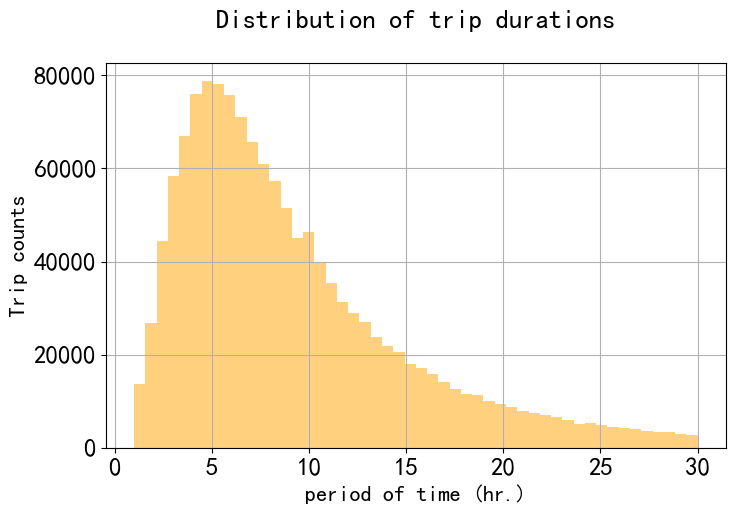

In [44]:
# Set font size for the plot
plt.rcParams.update({'font.size': 16})

# Plot histogram for trip durations
duration_mins.hist(figsize=(8, 5), alpha=0.5, bins=50, range=(1, 30), color='orange')  # Set figure size, bin count, transparency, and color

# Configure tick parameters for both axes
plt.tick_params(axis='both', which='major', labelsize=18)

# Set plot title and axis labels
plt.title('Distribution of Trip Durations\n')
plt.xlabel('Duration (min)')  # Set x-axis label
plt.ylabel('Trip Counts')      # Set y-axis label

## Distribution of Trip Start Times Throughout the Day

In [45]:
# Select only cycling duration and start time features, resulting in a DataFrame with two columns
df_sub = trace.loc[:, ['cycling_time_min', 'START_TIME']]

# Set start time as the DataFrame index
df_sub.index = df_sub['START_TIME']

# Group by hour of the day and count the number of trips per hour
countsPerHr = df_sub.groupby(df_sub.index.hour).size()  # Aggregates cycling counts for each of the 24 hours

Text(0, 0.5, 'Number of trips')

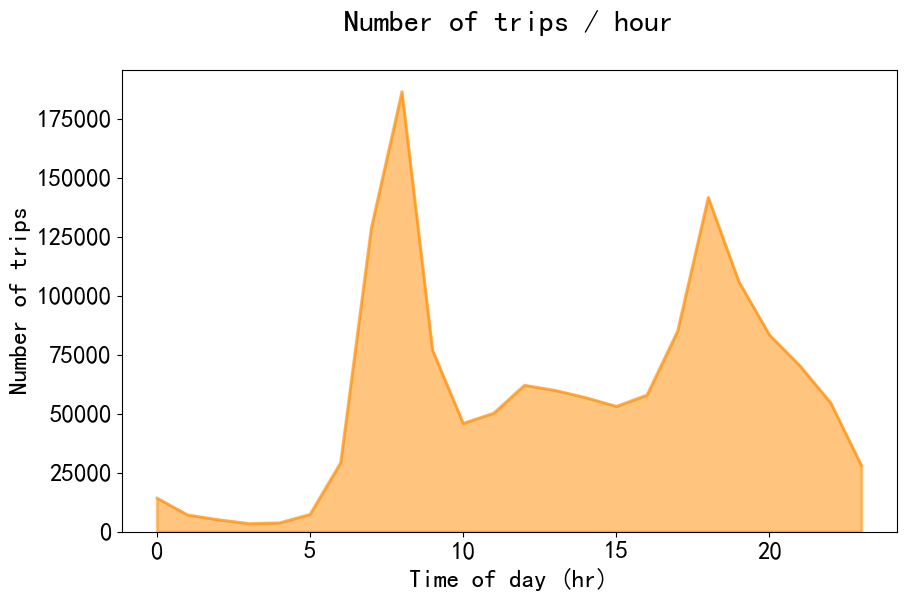

In [15]:
# Set font size for plot text and legend
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 20})

# Plot the hourly trip counts as an area plot
countsPerHr.plot(kind='area', stacked=False, figsize=(10, 6), color='darkorange', linewidth=2)

# Set tick parameters for better readability
plt.tick_params(axis='both', which='major', labelsize=18)

# Get current axis
ax = plt.gca()

# Set plot title and axis labels
plt.title('Number of Trips per Hour\n')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Number of Trips')

# 3 Trip Distance Statistics

### Straight-Line Distance

In [ ]:
# Calculate distance based on latitude and longitude
def getDistance(latA, lonA, latB, lonB):
    # Calculate the distance between two points given their latitude and longitude
    ra = 6378140  # Equatorial radius in meters
    rb = 6356755  # Polar radius in meters
    flatten = (ra - rb) / ra  # Earth's flattening ratio

    # Convert latitude and longitude from degrees to radians
    radLatA = math.radians(latA)
    radLonA = math.radians(lonA)
    radLatB = math.radians(latB)
    radLonB = math.radians(lonB)

    # Calculate reduced latitude using the Earth's polar radius
    pA = math.atan(rb / ra * math.tan(radLatA))
    pB = math.atan(rb / ra * math.tan(radLatB))

    # Calculate the central angle between the two points
    x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))

    # Calculate the correction factors for the Earth's flattening
    c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB)) ** 2 / math.cos(x / 2) ** 2
    c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB)) ** 2 / math.sin(x / 2) ** 2
    dr = flatten / 8 * (c1 - c2)

    # Calculate the final distance with the correction
    distance = int(ra * (x + dr))
    return distance

In [ ]:
trace['linear_dis'] = trace.apply(lambda x:getDistance(x['START_LNG_wgs84'],x['START_LAT_wgs84'],x['END_LNG_wgs84'],x['END_LAT_wgs84']),axis=1)
trace['linear_dis'] = round(trace['linear_dis']/1000,2)

In [ ]:
trace.head(5)

In [ ]:
# dgdf = gp.GeoDataFrame(ogdf, geometry=gp.points_from_xy(trace['END_LNG_wgs84'], trace['END_LAT_wgs84']), crs='EPSG:4326')
# temp2 = gp.sjoin(dgdf[['geometry']],grid_sz[['Input_FID','geometry']],op='intersects',how='left')
# temp2.head(5)
# trace['d_FID'] = temp2['Input_FID']
# trace.tail(5)

In [ ]:
trace.reset_index(inplace=True)
trace.tail()

In [ ]:
grid_sz.head(5)

In [ ]:
# Associate origin and destination coordinates
for i in range(trace.shape[0]):
    o_FID = trace.loc[i, 'o_FID']
    d_FID = trace.loc[i, 'd_FID']

    # Assign coordinates for the origin point
    trace.loc[i, 'o_lng'] = grid_sz.loc[o_FID, 'grid_lng']
    trace.loc[i, 'o_lat'] = grid_sz.loc[o_FID, 'grid_lat']

    # Assign coordinates for the destination point
    trace.loc[i, 'd_lng'] = grid_sz.loc[d_FID, 'grid_lng']
    trace.loc[i, 'd_lat'] = grid_sz.loc[d_FID, 'grid_lat']

    # Print progress every 100,000 iterations
    if i % 100000 == 0:
        print(i)

In [ ]:
trace = trace.loc[:, 'USER_ID':'d_lat']
trace.tail(5)

In [ ]:
trace.to_csv('D://004Vitality//02-Data//bike_out//trace_valid.csv')

### Road Network Distance

In [ ]:
G = ox.graph.graph_from_xml(filepath=r'D:\005城中村OD\data\shenzhen_trace3\data\shenzhen_map.osm', bidirectional=False, simplify=False, retain_all=False)

In [ ]:
ox.distance.add_edge_lengths(G, precision=3)

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [ ]:
gdf_nodes.head(5)

In [ ]:
print(G.number_of_nodes())
print(G.number_of_edges())

In [ ]:
# nx.get_edge_attributes(G, 'length')

In [ ]:
trace_valid = pd.read_csv('D://004Vitality//02-Data//bike_out//trace_valid.csv', index_col=0)
trace_valid.head(5)

In [ ]:
# Associate grid cells with nearest road network nodes
nearest_node_list, distance_list = ox.distance.nearest_nodes(
    G, grid_sz['grid_lng'].values, grid_sz['grid_lat'].values, return_dist=True
)

# Create a dictionary to store the nearest node and distance for each grid cell
grid_node_dis = {}
for i in range(grid_sz.shape[0]):
    grid_node_dis[grid_sz.loc[i, 'Input_FID']] = (nearest_node_list[i], distance_list[i])

In [ ]:
trace_valid['o_node'] = trace_valid['o_FID'].apply(lambda x:grid_node_dis[x][0])
trace_valid['o_node_dis']= trace_valid['o_FID'].apply(lambda x:grid_node_dis[x][1])
trace_valid['d_node'] = trace_valid['d_FID'].apply(lambda x:grid_node_dis[x][0])
trace_valid['d_node_dis']= trace_valid['d_FID'].apply(lambda x:grid_node_dis[x][1])

In [ ]:
trace_valid.head(5)

In [ ]:
# o_node_dis_sum = trace_valid.groupby(['o_FID']).sum()
# print(o_node_dis_sum.shape)
# o_node_dis_sum.head(5)

In [ ]:
# d_node_dis_sum = trace_valid.groupby(['d_FID']).sum()
# print(d_node_dis_sum.shape)
# d_node_dis_sum.head(5)

In [ ]:
# o_node_dis_sum.to_csv(r'D:\004Vitality\02-Data\bike_out\o_node_dis_sum.csv')
# d_node_dis_sum.to_csv(r'D:\004Vitality\02-Data\bike_out\d_node_dis_sum.csv')

In [ ]:
# Extract all unique origin-destination node pairs and save
od_node = trace_valid[['o_node', 'd_node']].drop_duplicates().values

# Uncomment to save the unique OD nodes to a file
# with open(r'../data/od_node.pkl', 'wb') as f:
#     pickle.dump(od_node, f)

# Print the number of unique OD node pairs
print(len(od_node))

In [ ]:
od_node = trace_valid.groupby(['o_node', 'd_node']).count()
od_node.head(5)

In [ ]:
od_node_pair = od_node.reset_index()
od_node_pair.head(5)
od_node_pair.to_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_count.csv')

### test

In [ ]:
short_path = nx.shortest_path(G, source=7088478146, target=8258853411, weight='length')

In [ ]:
print(type(short_path))
print(short_path)

In [ ]:
gdf_nodes.head(5)

In [ ]:
print(gdf_nodes.loc[short_path[0], 'x'])
print(gdf_nodes.loc[short_path[0], 'y'])

In [ ]:
temporary_coordinates = []
lines_merge = gp.GeoSeries()
for j in range(len(short_path)):
    temporary_coordinates.append((gdf_nodes.loc[short_path[j], 'x'], gdf_nodes.loc[short_path[j], 'y']))
print(temporary_coordinates)
lines = gp.GeoSeries([geometry.LineString(xy for xy in temporary_coordinates)], crs='EPSG:4326')
lines_merge = lines_merge.append(lines)

In [ ]:
print(type(lines_merge))

### Batch Processing

In [ ]:
od_df = pd.read_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_count_drop.csv', index_col=0)
od_df.head(5)

In [ ]:
od_node = od_df[['o_node', 'd_node']].values
od_node

In [ ]:
od_node[0][0]

In [ ]:
len(od_node)

In [ ]:
# Initialize an empty GeoSeries to store merged lines
lines_merge = gp.GeoSeries()

# Process each origin-destination node pair
for i in range(46585):
    try:
        # Find the shortest path between origin and destination nodes
        path = nx.shortest_path(G, source=od_node[i][0], target=od_node[i][1], weight='length')
        
        # Collect coordinates for each node in the path
        temporary_coordinates = []
        for j in range(len(path)):
            temporary_coordinates.append((gdf_nodes.loc[path[j], 'x'], gdf_nodes.loc[path[j], 'y']))
        
        # Create a line from the path coordinates and store in a GeoSeries
        lines = gp.GeoSeries([geometry.LineString(xy for xy in temporary_coordinates)], crs='EPSG:4326')
        
        # Append the created line to lines_merge
        lines_merge = lines_merge.append(lines)
        lines = gp.GeoSeries()  # Reset lines for the next iteration
    
    except:
        # Print the index if an error occurs for tracking
        print(i)
        pass
    
    # Print progress every 2000 iterations
    if i % 2000 == 0:
        print('Completed', i)

# Save the merged lines to a shapefile
lines_merge.to_file(r'D:\004Vitality\02-Data\bike_out\lines_merge.shp')

In [ ]:
print(lines_merge)

In [ ]:
od_fail = pd.read_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_fail.csv')

In [ ]:
fail_list = od_fail['DELETEID'].tolist()

In [ ]:
fail_list

In [ ]:
len(fail_list)

In [ ]:
od = pd.read_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_count_drop.csv')
od.tail(5)

In [ ]:
od.shape

In [ ]:
od_success = od[~od.ID.isin(fail_list)]
od_success.shape

In [ ]:
od_useless = od[od.ID.isin(fail_list)]
od_useless.shape

In [ ]:
od_success.to_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_count_useful.csv')

In [ ]:
od_useless.to_csv(r'D:\004Vitality\02-Data\bike_out\od_node_pair_count_useless.csv')

In [ ]:
trace_valid.shape

## 4 Trajectory Length Statistics Based on Grid

In [8]:
# Load trajectory data clipped using FME
trace_clip = gp.GeoDataFrame.from_file(r'D:\004Vitality\02-Data\bike_out\bike_trace_Project_clip\bike_trace_Project_clip.shp')

trace_clip.head(5)

,FID_1,ID,COUNT,Shape_Leng,Length,Length_Sum,geometry
0,0.0,0,2,12792.011888,426.654310,0.0,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
1,0.0,0,2,12792.011888,216.488684,0.0,"MULTILINESTRING ((222529.611 2501050.613, 222531.426 2501052.550, 222535.746 2501055.863, 222542..."
2,0.0,0,2,12792.011888,734.490797,0.0,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."
3,0.0,0,2,12792.011888,127.673428,0.0,"LINESTRING (222438.826 2499071.417, 222459.647 2499197.382)"
4,0.0,0,2,12792.011888,680.673498,0.0,"LINESTRING (219690.255 2500415.406, 219686.630 2500423.300, 219688.926 2500426.783, 219683.851 2..."


In [9]:
grid_sz.head(2)

,Id,Input_FID,geometry,grid_lng,grid_lat
0,0,0,"POLYGON ((113.83553 22.50517, 113.83805 22.50131, 113.83571 22.49736, 113.83086 22.49727, 113.82...",113.833196,22.501219
1,0,1,"POLYGON ((113.84290 22.50141, 113.84542 22.49755, 113.84308 22.49360, 113.83823 22.49350, 113.83...",113.840566,22.497457


In [10]:
print(trace_clip.shape)
print(grid_sz.shape)

(547470, 7)
(3294, 5)


In [24]:
trace_clip['Length_Sum'] = trace_clip['COUNT'] * trace_clip['Length']
trace_clip.head(10)

,FID_1,ID,COUNT,Shape_Leng,Length,Length_Sum,geometry
0,0.0,0,2,12792.011888,426.654310,853.308621,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
1,0.0,0,2,12792.011888,216.488684,432.977368,"MULTILINESTRING ((222529.611 2501050.613, 222531.426 2501052.550, 222535.746 2501055.863, 222542..."
2,0.0,0,2,12792.011888,734.490797,1468.981594,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."
3,0.0,0,2,12792.011888,127.673428,255.346856,"LINESTRING (222438.826 2499071.417, 222459.647 2499197.382)"
4,0.0,0,2,12792.011888,680.673498,1361.346995,"LINESTRING (219690.255 2500415.406, 219686.630 2500423.300, 219688.926 2500426.783, 219683.851 2..."
5,0.0,0,2,12792.011888,421.568645,843.137291,"MULTILINESTRING ((222305.457 2500848.419, 222308.948 2500865.343, 222324.969 2500896.558, 222334..."
6,0.0,0,2,12792.011888,1939.141396,3878.282791,"MULTILINESTRING ((222612.213 2500327.659, 222612.136 2500332.016, 222609.017 2500355.289, 222607..."
7,0.0,0,2,12792.011888,1705.732701,3411.465401,"MULTILINESTRING ((220247.271 2500269.227, 220330.444 2500220.109, 220334.809 2500226.412, 220317..."
8,0.0,0,2,12792.011888,522.412893,1044.825786,"LINESTRING (220995.878 2499838.627, 221005.799 2499836.912, 221044.714 2499820.213, 221081.814 2..."
9,0.0,0,2,12792.011888,712.786691,1425.573382,"LINESTRING (221395.285 2499549.381, 221428.388 2499503.388, 221503.633 2499422.110, 221576.707 2..."


In [25]:
trace_clip.to_csv(r'D:\004Vitality\02-Data\bike_out\20230418bike_trace_length.csv')

In [58]:
trace_clip.crs

<Derived Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°E and 120°E, northern hemisphere between equator and 84°N, onshore and offshore. Brunei. China. Hong Kong. Indonesia. Malaysia - East Malaysia - Sarawak. Mongolia. Philippines. Russian Federation. Taiwan.
- bounds: (114.0, 0.0, 120.0, 84.0)
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
grid_sz.to_crs('EPSG:32650', inplace=True)

In [57]:
grid_sz.crs

<Derived Projected CRS: EPSG:32650>
Name: WGS 84 / UTM zone 50N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°E and 120°E, northern hemisphere between equator and 84°N, onshore and offshore. Brunei. China. Hong Kong. Indonesia. Malaysia - East Malaysia - Sarawak. Mongolia. Philippines. Russian Federation. Taiwan.
- bounds: (114.0, 0.0, 120.0, 84.0)
Coordinate Operation:
- name: UTM zone 50N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
grid_trace = gp.sjoin(left_df=grid_sz, right_df=trace_clip, how='right', op='covers')
# grid_trace = gp.sjoin(left_df=trace_clip, right_df=grid_sz, how='left', op='covered_by')
grid_trace.head(5)

,index_left,Id,Input_FID,grid_lng,grid_lat,FID_1,ID,COUNT,Shape_Leng,Length,Length_Sum,geometry
0,3293.0,0.0,3293.0,114.283330,22.579803,0.0,0,2,12792.011888,426.654310,853.308621,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
1,2116.0,0.0,2116.0,114.304965,22.591894,0.0,0,2,12792.011888,216.488684,432.977368,"MULTILINESTRING ((222529.611 2501050.613, 222531.426 2501052.550, 222535.746 2501055.863, 222542..."
2,NaN,NaN,NaN,NaN,NaN,0.0,0,2,12792.011888,734.490797,1468.981594,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."
3,NaN,NaN,NaN,NaN,NaN,0.0,0,2,12792.011888,127.673428,255.346856,"LINESTRING (222438.826 2499071.417, 222459.647 2499197.382)"
4,NaN,NaN,NaN,NaN,NaN,0.0,0,2,12792.011888,680.673498,1361.346995,"LINESTRING (219690.255 2500415.406, 219686.630 2500423.300, 219688.926 2500426.783, 219683.851 2..."


In [55]:
grid_fail = grid_trace[grid_trace[['Input_FID']].isnull().T.any()]
grid_fail.shape

(359717, 12)

In [56]:
grid_trace.shape

(547470, 12)

In [19]:
grid_trace.reset_index(inplace=True)
grid_trace.head(5)

,index,index_left,Id,Input_FID,grid_lng,grid_lat,FID_1,ID,COUNT,Shape_Leng,Length,Length_Sum,geometry
0,0,1995,0,1995,114.283176,22.587618,0.0,0,2,12792.011888,426.654310,853.308621,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
1,0,3293,0,3293,114.283330,22.579803,0.0,0,2,12792.011888,426.654310,853.308621,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
2,1,2116,0,2116,114.304965,22.591894,0.0,0,2,12792.011888,216.488684,432.977368,"MULTILINESTRING ((222529.611 2501050.613, 222531.426 2501052.550, 222535.746 2501055.863, 222542..."
3,2,1990,0,1990,114.297905,22.580049,0.0,0,2,12792.011888,734.490797,1468.981594,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."
4,2,2112,0,2112,114.305117,22.584079,0.0,0,2,12792.011888,734.490797,1468.981594,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."


In [20]:
grid_drop = grid_trace[['index']].drop_duplicates()
grid_drop.shape

(547470, 1)

In [21]:
grid_trace_sum = grid_trace.groupby('Input_FID').sum()

In [22]:
grid_trace_sum.head()

,index,index_left,Id,grid_lng,grid_lat,FID_1,ID,COUNT,Shape_Leng,Length,Length_Sum
Input_FID,,,,,,,,,,,
6,72196696,2988,0,56688.132390,11240.619004,6245056.0,6245056,7102,7.091003e+06,3.251240e+06,2.888145e+07
7,279835745,10262,0,166876.850555,33101.306132,24174137.0,24174137,18082,3.256386e+07,2.185824e+07,1.404397e+08
8,175887538,6456,0,91861.805471,18227.827855,15299344.0,15299344,11442,1.170833e+07,9.057892e+06,6.532602e+07
9,65329324,1944,0,24581.135100,4883.760706,5595839.0,5595839,610,6.100960e+06,5.547727e+06,1.662497e+07
10,121747753,4970,0,56563.037094,11235.302644,10456354.0,10456354,4928,1.182092e+07,1.080951e+07,6.696365e+07


In [23]:
grid_trace_sum.to_csv(r'D:\004Vitality\02-Data\bike_out\20230418grid_trace_length.csv')

### Associate Using Centroids

In [66]:
grid_trace = gp.sjoin_nearest(left_df=grid_point, right_df=trace_clip, how='right')
# grid_trace = gp.sjoin(left_df=trace_clip, right_df=grid_sz, how='left', op='covered_by')
grid_trace.head(5)

,index_left,Id,Input_FID,o_FID,o_node_dis,d_FID,d_node_dis,Shape_Leng_left,Shape_Area,ORIG_FID,FID_1,ID,COUNT,Shape_Leng_right,Length,Length_Sum,geometry
0,1372,0,3293,3293,8544.069358,3293,9227.594907,2999.999993,649519.050000,1373,0.0,0,2,12792.011888,426.654310,853.308621,"LINESTRING (220613.579 2499982.394, 220661.879 2499940.031, 220698.816 2499909.127, 220714.710 2..."
1,1272,0,2116,2116,292.623345,2116,585.246690,2999.999993,649519.050000,1273,0.0,0,2,12792.011888,216.488684,432.977368,"MULTILINESTRING ((222529.611 2501050.613, 222531.426 2501052.550, 222535.746 2501055.863, 222542..."
2,2240,0,2112,0,0.000000,0,0.000000,2999.999993,649519.050001,2241,0.0,0,2,12792.011888,734.490797,1468.981594,"LINESTRING (222566.304 2499716.645, 222569.305 2499734.378, 222569.945 2499746.988, 222574.173 2..."
3,2239,0,2110,0,0.000000,0,0.000000,2999.999993,649519.050000,2240,0.0,0,2,12792.011888,127.673428,255.346856,"LINESTRING (222438.826 2499071.417, 222459.647 2499197.382)"
4,2201,0,2069,0,0.000000,0,0.000000,2999.999993,649519.050000,2202,0.0,0,2,12792.011888,680.673498,1361.346995,"LINESTRING (219690.255 2500415.406, 219686.630 2500423.300, 219688.926 2500426.783, 219683.851 2..."


In [67]:
grid_fail = grid_trace[grid_trace[['Input_FID']].isnull().T.any()]
grid_fail.shape

(0, 17)

In [68]:
grid_trace.shape

(547470, 17)

In [69]:
grid_trace_sum = grid_trace.groupby('Input_FID').sum()
grid_trace_sum.head(5)

,index_left,Id,o_FID,o_node_dis,d_FID,d_node_dis,Shape_Leng_left,Shape_Area,ORIG_FID,FID_1,ID,COUNT,Shape_Leng_right,Length,Length_Sum
Input_FID,,,,,,,,,,,,,,,
6,0,0,1500,5.940625e+06,1500,5.500579e+05,7.500000e+05,1.623798e+08,250,3134445.0,3134445,3553,3.547129e+06,1.582420e+06,1.370887e+07
7,511,0,3577,7.370219e+07,3577,5.816453e+07,1.533000e+06,3.319042e+08,1022,8340860.0,8340860,6425,1.183524e+07,7.699820e+06,4.879310e+07
8,1350,0,5400,1.753091e+08,5400,2.640614e+08,2.025000e+06,4.384254e+08,2025,12551306.0,12551306,9997,1.069709e+07,8.135413e+06,5.768050e+07
9,393,0,1179,1.504184e+05,1179,3.269966e+03,3.930000e+05,8.508700e+07,524,3344002.0,3344002,428,4.289846e+06,3.849168e+06,1.326100e+07
10,932,0,2330,2.131537e+06,2330,1.353357e+05,6.990000e+05,1.513379e+08,1165,5197143.0,5197143,1856,5.724722e+06,5.211253e+06,2.741188e+07


In [71]:
grid_trace_sum.to_csv(r'D:\004Vitality\02-Data\bike_out\20230418grid_trace_length.csv')